In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import MultivariateNormalDataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_gpus = 1 if device=='cuda' else 0
print(device)

cuda


In [4]:
%load_ext autoreload
%autoreload 2
from models.mine import MutualInformationEstimator
from pytorch_lightning import Trainer
import logging
logging.getLogger().setLevel(logging.ERROR)

dim = 1
N = 3000
lr = 1e-4
epochs = 200
batch_size = 500

steps = 15
rhos = np.linspace(-0.99, 0.99, steps)
loss_type = ['mine_biased']

results_dict = dict()

for loss in loss_type:
    results = []
    for rho in rhos:
        train_loader = torch.utils.data.DataLoader(
        MultivariateNormalDataset(N, dim, rho), batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(
        MultivariateNormalDataset(N, dim, rho), batch_size=batch_size, shuffle=True)

        
        true_mi = train_loader.dataset.true_mi

        kwargs = {
            'lr': lr,
            'batch_size': batch_size,
            'train_loader': train_loader,
            'test_loader': test_loader,
            'alpha': 1.0
        }

        model = MutualInformationEstimator(
            dim, dim, loss=loss, **kwargs).to(device)
        
        trainer = Trainer(max_epochs=epochs, early_stop_callback=False, gpus=num_gpus)
        trainer.fit(model)
        trainer.test()

        print("True_mi {}".format(true_mi))
        print("MINE {}".format(model.avg_test_mi))
        results.append((rho, model.avg_test_mi, true_mi))

    results = np.array(results)
    results_dict[loss] = results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Testing: 100%|██████████| 6/6 [00:00<00:00, 228.25batch/s]
True_mi 1.9585182666778564
MINE 1.7592424154281616
Testing: 100%|██████████| 6/6 [00:00<00:00, 217.39batch/s]
True_mi 0.6366140246391296
MINE 0.5953158140182495
Testing: 100%|██████████| 6/6 [00:00<00:00, 221.10batch/s]
True_mi 0.34662458300590515
MINE 0.33796820044517517
Testing: 100%|██████████| 6/6 [00:00<00:00, 219.99batch/s]
True_mi 0.19285525381565094
MINE 0.17817780375480652
Testing: 100%|██████████| 6/6 [00:00<00:00, 228.47batch/s]
True_mi 0.09923666715621948
MINE 0.10427713394165039
Testing: 100%|██████████| 6/6 [00:00<00:00, 217.35batch/s]
True_mi 0.041695233434438705
MINE 0.0624389611184597
Testing: 100%|██████████| 6/6 [00:00<00:00, 221.41batch/s]
True_mi 0.0101024080067873
MINE 0.01829810068011284
Testing: 100%|██████████| 6/6 [00:00<00:00, 220.85batch/s]
True_mi -0.0
MINE 0.00547037273645401
Testing: 100%|██████████| 6/6 [00:00

/home/gustaf/anaconda3/envs/fun/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  # This is added back by InteractiveShellApp.init_path()


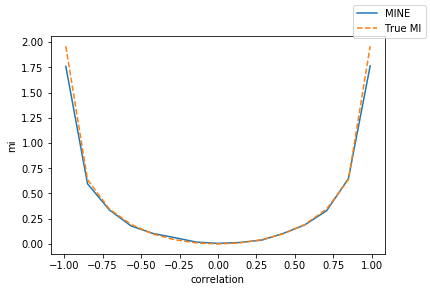

In [116]:
fig, axs = plt.subplots(1, len(loss_type), sharex = True, figsize = (6,4))
plots = []
for ix, loss in enumerate(loss_type):
    results = results_dict[loss]
    plots += axs.plot(results[:,0], results[:,1], label='MINE')
    plots += axs.plot(results[:,0], results[:,2], linestyle='--', label='True MI')
    axs.set_xlabel('correlation')
    axs.set_ylabel('mi')
    #axs.title.set_text(f"{loss} for {dim} dimensional inputs")
    
fig.legend(plots[0:2], labels = ['MINE', 'True MI'], loc='upper right')
fig.savefig('figures/mi_estimation.png')
    
    

In [6]:
## Function experiment
N = 3000
lr = 1e-4
batch_size = 256
epochs = 200

def f1(x): return x
def f2(x): return x**3
def f3(x): return torch.sin(x)

sigmas = torch.linspace(0, 0.9, 10)
fs = [f1, f2, f3]
dim = 2

res = []
for sigma in sigmas:
    for ix, f in enumerate(fs):
        print(f"Experiment: {ix + 1}, Sigma: {sigma}...")

        kwargs = {
            'N': N,
            'sigma': sigma,
            'f': f,
            'lr': lr,
            'batch_size': batch_size,
            'alpha': 0.1
        }

        model = MutualInformationEstimator(
            dim, dim, loss='mine_biased', **kwargs).to(device)
        trainer = Trainer(max_epochs=epochs,
                          early_stop_callback=False, gpus=num_gpus)
        trainer.fit(model)
        trainer.test()

        # Append result
        res.append([ix, sigma, model.avg_test_mi])


Experiment: 1, Sigma: 0.0...
Testing: 100%|██████████| 12/12 [00:00<00:00, 532.19batch/s]
Experiment: 2, Sigma: 0.0...
Testing: 100%|██████████| 12/12 [00:00<00:00, 585.62batch/s]
Experiment: 3, Sigma: 0.0...
Testing: 100%|██████████| 12/12 [00:00<00:00, 533.74batch/s]
Experiment: 1, Sigma: 0.09999999403953552...
Testing: 100%|██████████| 12/12 [00:00<00:00, 570.89batch/s]
Experiment: 2, Sigma: 0.09999999403953552...
Testing: 100%|██████████| 12/12 [00:00<00:00, 583.09batch/s]
Experiment: 3, Sigma: 0.09999999403953552...
Testing: 100%|██████████| 12/12 [00:00<00:00, 480.40batch/s]
Experiment: 1, Sigma: 0.19999998807907104...
Testing: 100%|██████████| 12/12 [00:00<00:00, 552.98batch/s]
Experiment: 2, Sigma: 0.19999998807907104...
Testing: 100%|██████████| 12/12 [00:00<00:00, 536.72batch/s]
Experiment: 3, Sigma: 0.19999998807907104...
Testing: 100%|██████████| 12/12 [00:00<00:00, 556.36batch/s]
Experiment: 1, Sigma: 0.29999998211860657...
Testing: 100%|██████████| 12/12 [00:00<00:00, 576

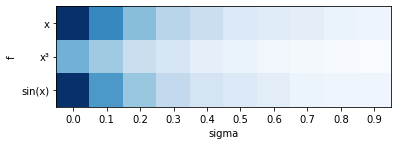

In [24]:
res = np.array(res)
Z = res[:, -1].reshape((len(sigmas), len(fs))).T
plt.figure()
plt.imshow(Z, cmap='Blues')
plt.yticks([0,1,2],['x', 'x³', 'sin(x)'])
plt.xticks(np.arange(10),sigmas.numpy().round(2))
plt.xlabel('sigma')
plt.ylabel('f')
plt.show()

## GANs

In [105]:
%load_ext autoreload
%autoreload 2
# GAN spiral experiment
from models.gan import GAN
from models.mine import T, Mine
from datasets import load_dataloader
from pytorch_lightning import Trainer

from collections import defaultdict

datasets = ['gaussians']
loss = 'mine_biased'
num_samples = 4000
batch_size = 256
epochs = 600
lr = 1e-4
betas = [0.0, 1.0]
alpha = 0.1
#dataset = 'spiral'

results = defaultdict(dict)

for dataset in datasets:
    for beta in betas:
        train_loader = load_dataloader(dataset, batch_size, N=num_samples)
        img, label = next(iter(train_loader))

        output_dim = np.prod(img.shape[1:])
        input_dim = 100
        lr = lr
        beta = beta

        kwargs = {
            'lr': lr,
            'train_loader': train_loader,
            'beta': beta,
            'alpha': alpha,
            'use_conditional': True,
            'condition_on_labels': True
        }

        mi_model = T(output_dim, label.shape[-1]).to(device)
        mi_estimator = Mine(mi_model, loss=loss).to(device)

        model = GAN(input_dim, 
                    output_dim, 
                    device=device,
                   generator_type = 'linear', 
                    discriminator_type = 'linear', 
                    mi_estimator=mi_estimator, 
                    conditional_dim=label.shape[-1], **kwargs).to(device)

        trainer = Trainer(max_epochs=epochs, early_stop_callback = False, gpus=num_gpus)
        trainer.fit(model)

        generated_grid, conditional = model.generate_img_grid(num_samples)
        results[dataset][beta] = [generated_grid.cpu().data.numpy(), conditional.cpu().data.numpy()]
    
    


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 600: 100%|██████████| 16/16 [00:00<00:00, 29.28batch/s, batch_idx=15, d_loss=0.647, g_loss=-2.01, gpu=0, loss=-0.810, v_num=957]


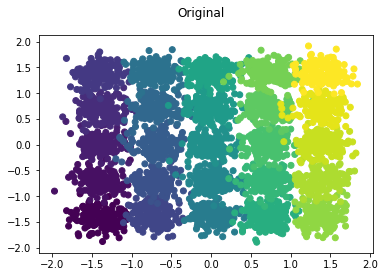

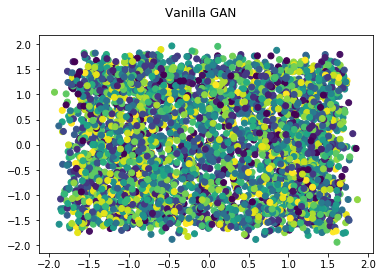

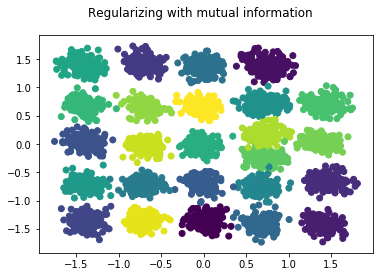

In [111]:
from datasets import to_onehot

data = train_loader.dataset
x_np = data.x_np
labels = data.labels

plt.figure()
plt.scatter(x_np[:,0], x_np[:,1], c = labels)
plt.suptitle('Original')
plt.savefig('figures/25gaussians.png')

dataset = 'gaussians'
generated_grid, conditional = results[dataset][0.0]
model.plot_grid(generated_grid, conditional)
title = plt.suptitle('Vanilla GAN')
plt.savefig('figures/25gaussians_gan.png')

#plt.figure()
generated_grid, conditional = results[dataset][1.0]
model.plot_grid(generated_grid, conditional)
title = plt.suptitle('Regularizing with mutual information')
plt.savefig('figures/25gaussians_mine.png')

In [123]:
## IBNetwork on MNIST

In [122]:
from models.information_bottleneck import IBNetwork, StatisticsNetwork
from models.mine import Mine

batch_size = 512
epochs = 100
K = 256
beta = 1e-3
lr = 1e-3
x_dim = 28*28
z_dim = K


t = StatisticsNetwork(x_dim, z_dim, device=device).to(device)
mi_estimator = Mine(t, loss='mine', method='concat').to(device)
ibnetwork = IBNetwork(input_dim=28*28, K=K, output_dim=10,
                      mi_estimator=mi_estimator, lr=lr, beta=beta).to(device)

trainer = Trainer(max_epochs=epochs,
                  gpus=1, early_stop_callback=False)
trainer.fit(ibnetwork)

[autoreload of models.mine failed: Traceback (most recent call last):
  File "/home/gustaf/anaconda3/envs/fun/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/gustaf/anaconda3/envs/fun/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/gustaf/anaconda3/envs/fun/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/gustaf/anaconda3/envs/fun/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/gustaf/anaconda3/envs/fun/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/gustaf/anaconda3/envs/fun/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in update_

Device: cuda


Epoch 1:   1%|          | 3/275 [00:00<00:15, 17.90batch/s, accuracy=0.211, batch_idx=2, error_rate=0.789, gpu=0, loss=2.304, v_num=959]

Epoch 2:   1%|          | 2/275 [00:00<00:06, 40.24batch/s, accuracy=0.965, batch_idx=1, error_rate=0.0352, gpu=0, loss=0.178, v_num=959]    

/home/gustaf/anaconda3/envs/fun/lib/python3.6/site-packages/pytorch_lightning/trainer/training_io.py:342: UserWarning: Did not find hyperparameters at model.hparams. Saving checkpoint without hyperparameters
  "Did not find hyperparameters at model.hparams. Saving checkpoint without"


Epoch 2:  56%|█████▌    | 154/275 [00:06<00:05, 22.88batch/s, accuracy=0.938, batch_idx=153, error_rate=0.0625, gpu=0, loss=0.118, v_num=959] 

KeyboardInterrupt: 